# **Libraries**

In [ ]:
from IPython import get_ipython
from IPython.display import display

!pip install scikit-learn

!pip install --upgrade scikit-learn

!pip show scikit-learn scikeras

!pip install --upgrade scikit-learn scikeras

!pip install keras-tuner

!pip install lime

!pip install scikeras

!pip install --upgrade shap

import shap
shap.initjs()

!pip install tensorflow


!pip install tensorflow


import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from collections import Counter
from xgboost import XGBClassifier

# **Pre-Processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/World Energy Consumption.csv"
df = pd.read_csv(file_path)

df.info()

print(df.head())


print(df.tail())

# Assume the target column is named 'primary_energy_consumption'
target_column = 'primary_energy_consumption'

# Separate numeric and categorical features before one-hot encoding
X_numerical = df.drop(target_column, axis=1).select_dtypes(include=np.number)
X_categorical = df.drop(target_column, axis=1).select_dtypes(include='object')

# One-hot encode categorical features
X_categorical_encoded = pd.get_dummies(X_categorical)

# Combine numerical and encoded categorical features
X = pd.concat([X_numerical, X_categorical_encoded], axis=1)

# Now, perform data splitting
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB
         country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  ASEAN (Ember)  2000      NaN         NaN  NaN                      NaN   
1  ASEAN (Ember)  2001      NaN         NaN  NaN                      NaN   
2  ASEAN (Ember)  2002      NaN         NaN  NaN                      NaN   
3  ASEAN (Ember)  2003      NaN         NaN  NaN                      NaN   
4  ASEAN (Ember)  2004      NaN         NaN  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN             

In [ ]:
# Initialize the feature selector
selector = ExtraTreesRegressor(n_estimators=100, random_state=42)  # Use regressor


# Before fitting, drop rows with NaN in the target variable from both X_train and y_train
X_train_cleaned = X_train[y_train.notna()]
y_train_cleaned = y_train[y_train.notna()]


# Fit the selector to your cleaned training data
selector.fit(X_train_cleaned, y_train_cleaned)

# Get feature importances
feature_importances = selector.feature_importances_

# Define the number of features to select (k)
k = 10  # Example: Select top 10 features

# Select top k features based on importance
indices = np.argsort(feature_importances)[::-1][:k]
X_train_selected = X_train.iloc[:, indices]
X_test_selected = X_test.iloc[:, indices]

In [ ]:
import pandas as pd

# Define bins and labels
bins = [0, 1000, 2000, float('inf')]  # Example bins
labels = ['low', 'medium', 'high']

# Bin the target variable
y_train_cleaned = pd.cut(y_train_cleaned, bins=bins, labels=labels)

# **Correlation Heatmap**

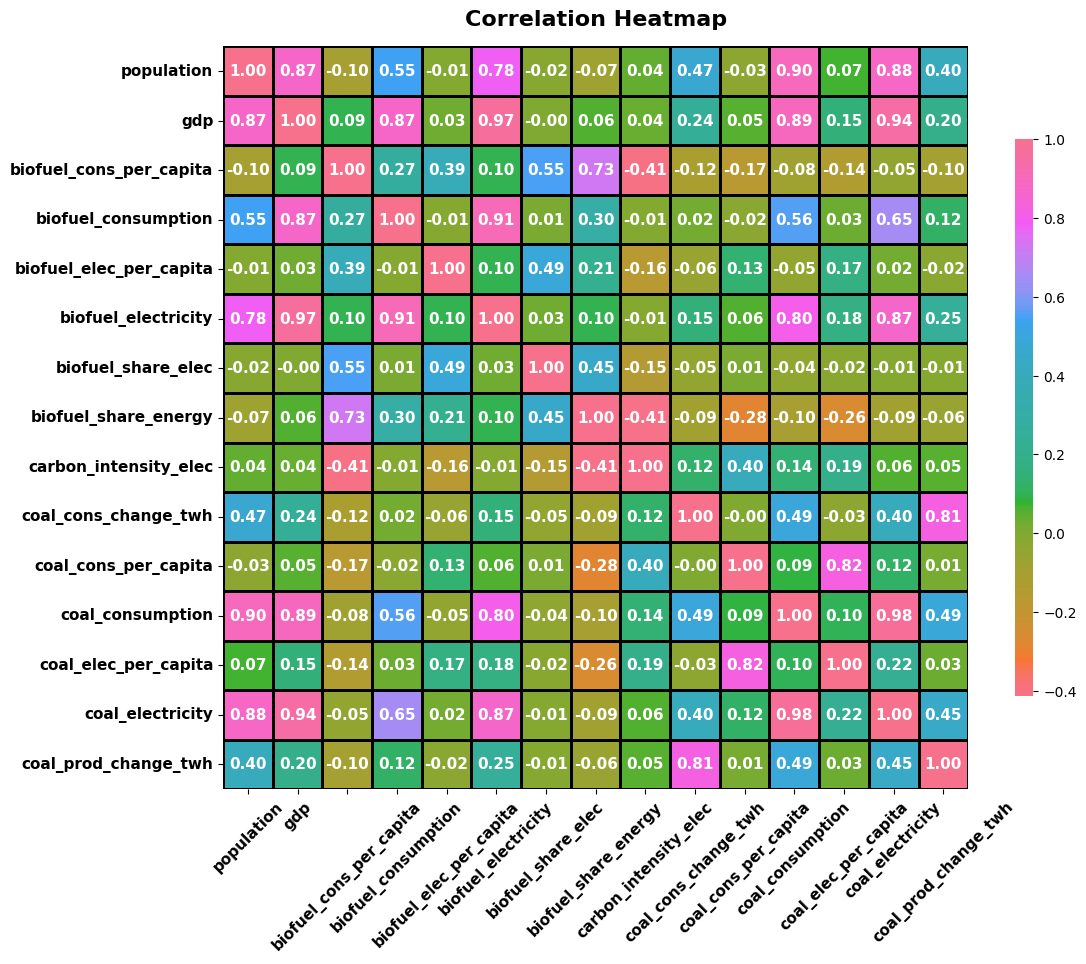

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select all numeric columns without altering the data
numeric_df = X_train.select_dtypes(include=['number'])

# Step 2: Compute correlation matrix (pandas automatically skips NaNs in pairwise correlations)
correlation_matrix = numeric_df.corr()

# Step 3: Keep only columns with at least one VERY strong correlation (excluding self-correlation)
# Increased threshold to 0.7 for stronger correlations
strong_corr_mask = (correlation_matrix.abs() >= 0.7).sum(axis=1) > 1
focused_corr_matrix = correlation_matrix.loc[strong_corr_mask, strong_corr_mask]

# --- Reducing the number of attributes ---
# Select a subset of columns (you might need to adjust this based on your data)
selected_columns = focused_corr_matrix.columns[:15]  # Select the first 10 columns
focused_corr_matrix = focused_corr_matrix.loc[selected_columns, selected_columns]

# Step 4: Define color palette for the heatmap
cmap = sns.color_palette("husl", as_cmap=True) # Use the original colormap

# Step 5: Plot the heatmap with adjusted figure size
plt.figure(figsize=(12, 10))  # Adjusted figure size (reduce if needed)
sns.heatmap(focused_corr_matrix, annot=True, cmap=cmap, linewidths=2,
            linecolor='black', fmt=".2f", annot_kws={"fontsize": 11, "fontweight": "bold"},
            cbar_kws={'shrink': 0.75, 'aspect': 30})

plt.xticks(fontsize=11, fontweight='bold', rotation=45, color="black")
plt.yticks(fontsize=11, fontweight='bold', rotation=0, color="black")

plt.title("Correlation Heatmap",
          fontsize=16, fontweight='bold', color="black", pad=15)

plt.tight_layout(pad=2)
plt.show()

# **Pair Plot**

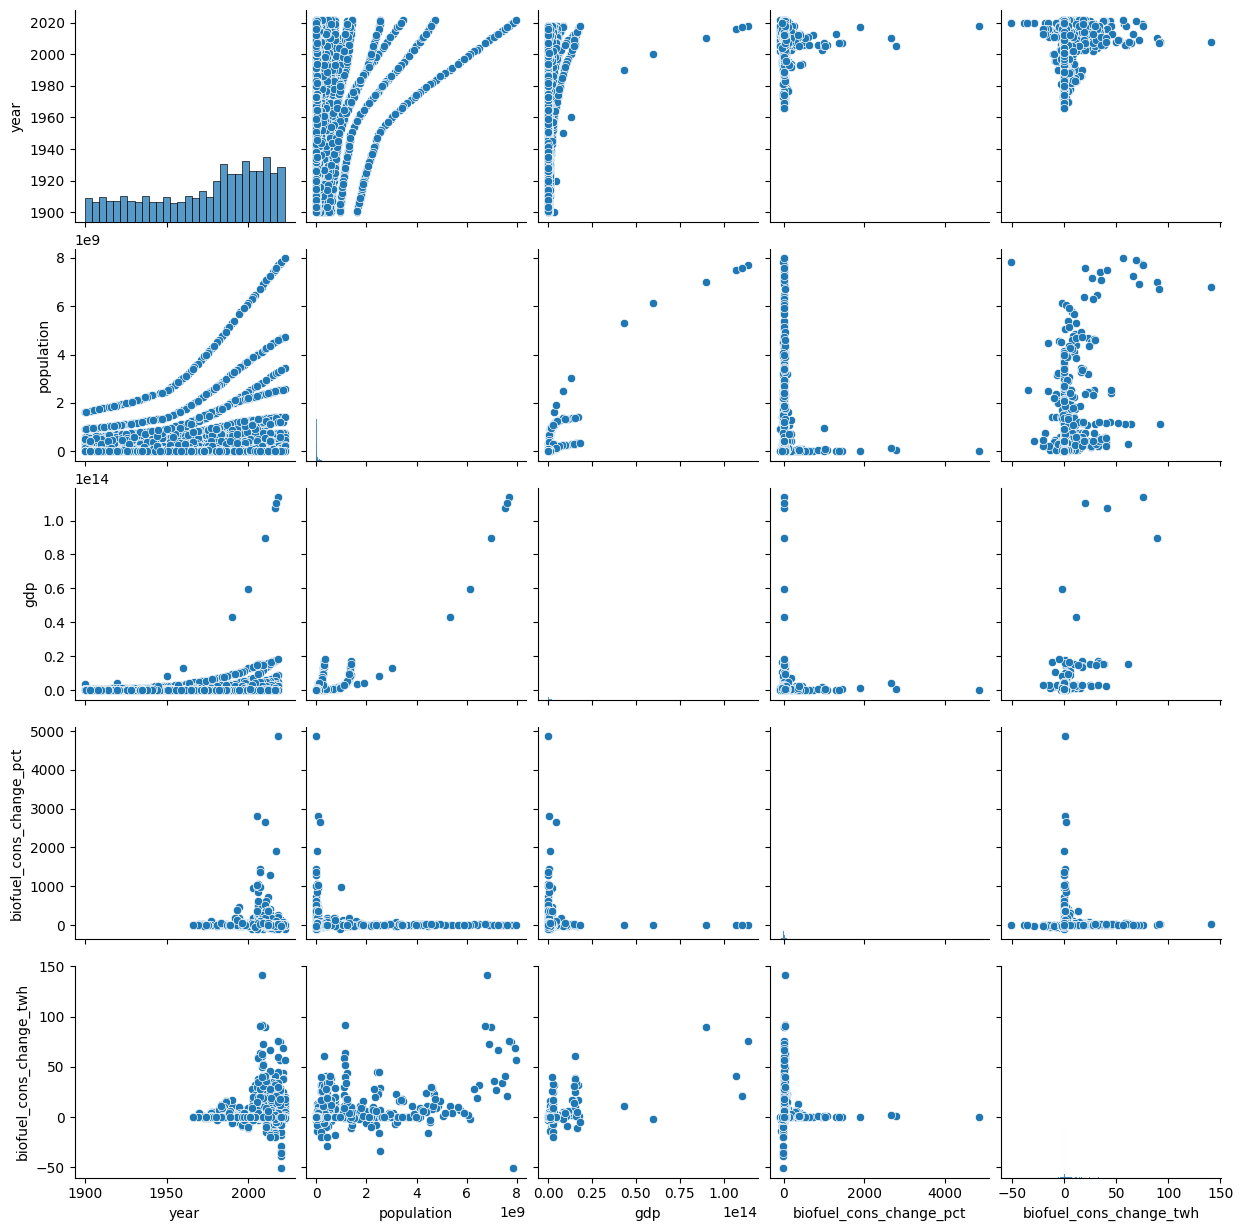

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'numeric_df' is your DataFrame with numerical features
# If not, replace 'numeric_df' with your actual DataFrame

# Select a subset of columns for the pair plot (optional)
selected_columns = numeric_df.columns[:5] # Example: first 5 columns
sns.pairplot(numeric_df[selected_columns])
plt.show()

# **Label Encoding of Categorical Features**

In [ ]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in X_categorical.columns:
    # Fit and transform the column using LabelEncoder
    X_categorical[column] = label_encoder.fit_transform(X_categorical[column])

# Now X_categorical contains numerical representations of your categorical features
print(X_categorical.head())

   country  iso_code
0        0       219
1        0       219
2        0       219
3        0       219
4        0       219


# **KDE Graph (Before & After Normalization)**



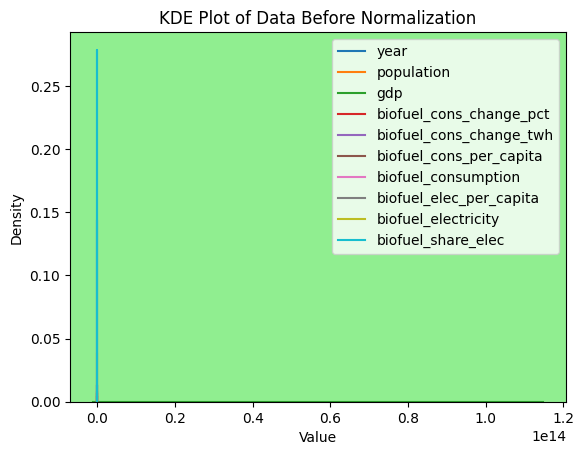

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'X_train' is your DataFrame containing the original data before normalization
# Select the columns you want to visualize
columns_to_plot = X_train.columns[:10]  # Example: first 10 columns, adjust as needed

# Create the KDE plot for each selected column
for column in columns_to_plot:
    sns.kdeplot(X_train[column], label=column)

# Customize the plot (optional)
plt.title("KDE Plot of Data Before Normalization")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Set background color to light green
plt.gca().set_facecolor('lightgreen')

# Show the plot
plt.show()

In [ ]:
# Normalization of data
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames (optional, but often useful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Now X_train_scaled and X_test_scaled contain the normalized data
print(X_train_scaled.head())

       year  population  gdp  biofuel_cons_change_pct  \
0 -0.751094         NaN  NaN                      NaN   
1  0.277032         NaN  NaN                      NaN   
2 -1.322276   -0.221291  NaN                      NaN   
3  0.791096    1.335882  NaN                -0.037653   
4 -1.779221   -0.050680  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                 0.016771                 -0.43807            -0.232854   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  biofuel_electricity  biofuel_share_elec  ...  \
0                      NaN                  NaN                 NaN  ...   
1                      NaN                  NaN 

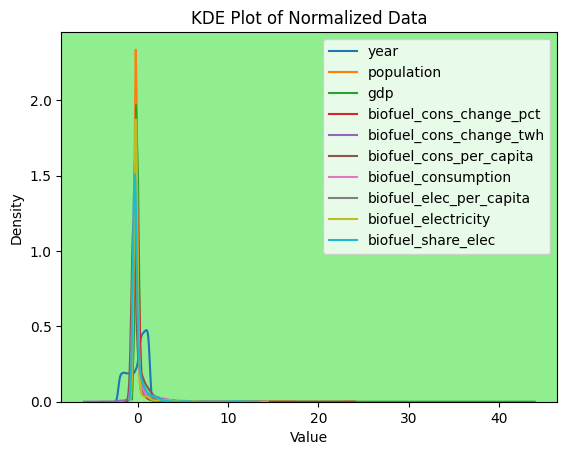

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train_scaled is your DataFrame containing normalized data
# Select the columns you want to visualize
columns_to_plot = X_train_scaled.columns[:10]  # Example: first 5 columns, adjust as needed

# Create the KDE plot
for column in columns_to_plot:
    sns.kdeplot(X_train_scaled[column], label=column)

# Customize the plot (optional)
plt.title("KDE Plot of Normalized Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Set background color to light green
plt.gca().set_facecolor('lightgreen')

# Show the plot
plt.show()


# **ANN Model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# ... (Your existing code for data loading, preprocessing, etc.) ...

# Assuming X and y are your feature and target data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Clean and Preprocess Target Variable (y_train) ---

# 1. Remove or Impute NaN Values:
# You can either remove rows with NaN values or impute them with a suitable value
# (e.g., mean, median, or a separate category).
# Here, we'll remove rows with NaN for simplicity.
X_train = X_train[y_train.notna()]  # Remove rows with NaN in target from X_train
y_train = y_train[y_train.notna()]  # Remove rows with NaN in target from y_train

# 2. Define bins and labels
bins = [0, 1000, 2000, float('inf')]  # Example bins
labels = [0, 1, 2]  # Using numerical labels for classes

# 3. Bin the target variable, include lowest value and drop duplicates
y_train = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True, duplicates='drop')

# 4. Convert to numerical values if necessary
y_train = pd.to_numeric(y_train)

# 5. Repeat steps 1-4 for y_test
X_test = X_test[y_test.notna()]  # Remove rows with NaN in target from X_test
y_test = y_test[y_test.notna()]  # Remove rows with NaN in target from y_test
y_test = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True, duplicates='drop')
y_test = pd.to_numeric(y_test)

# ... (Rest of your code, including the build_ann_model function and Keras Tuner) ...

# Define the ANN model building function for Keras Tuner
def build_ann_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    # Assuming your task is classification with 3 classes (low, medium, high)
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the Keras Tuner (e.g., RandomSearch)
tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    directory='my_dir',  # Directory to store results
    project_name='ann_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters.values)

Reloading Tuner from my_dir/ann_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'units_1': 320, 'dropout_1': 0.0, 'units_2': 384, 'dropout_2': 0.1, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Reloading Tuner from my_dir/ann_tuning/tuner0.json
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7510 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7471 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7457 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7493 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7457 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7551 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7473 - loss: nan - val_accuracy: 0.7558 - val_loss: nan
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7449 - loss: nan - va

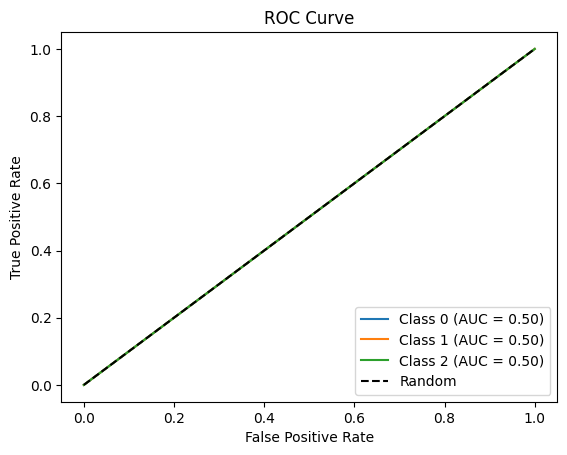

Computational Time: 251.08 seconds
Training Accuracy: 0.7475
Testing Accuracy: 0.7558
Precision: 0.2519
Recall: 0.3333
F1-Score: 0.2870
Matthews Correlation Coefficient (MCC): 0.0000
Specificity: 0.7558


In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
import keras_tuner as kt  # Import Keras Tuner correctly
from sklearn.preprocessing import LabelBinarizer

# Train ANN Model
def build_ann_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    # Assuming your task is classification with 3 classes (low, medium, high)
    model.add(Dense(3, activation='softmax'))  # Output layer for classification with 3 classes
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for classification with integer labels
                  metrics=['accuracy'])
    return model

# Train Model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    start_time = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size, verbose=1)
    end_time = time.time()
    computational_time = end_time - start_time

    # Predictions
    y_train_pred_probs = model.predict(X_train)
    y_test_pred_probs = model.predict(X_test)

    # Get predicted labels (class with highest probability)
    y_train_pred = np.argmax(y_train_pred_probs, axis=1)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)  # Fixed typo here
    mcc = matthews_corrcoef(y_test, y_test_pred)  # Added Matthews Correlation Coefficient

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Instead of unpacking directly, access elements using indices
    # Assuming 3 classes (0, 1, 2) - adjust indices if different
    tn = cm[0, 0] + cm[1, 1] + cm[2, 2]  # Sum of diagonal elements for TN (all correctly classified)
    fp = np.sum(cm) - tn # Total predictions minus correctly classified for FP
    fn = np.sum(cm) - tn # Total predictions minus correctly classified for FN
    tp = tn # total predictions is equal to total actuals, so tp = tn

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle zero division

    # ROC Curve for multi-class classification (One-vs-Rest approach)
    n_classes = model.layers[-1].units  # Number of classes
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_test_pred_probs_bin = lb.transform(y_test_pred)  # Convert to binary for each class

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_probs_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


    print(f"Computational Time: {computational_time:.2f} seconds")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return history, computational_time, train_acc, test_acc, precision, recall, f1, mcc, specificity  # Return all metrics


# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_accuracy',  # Objective to optimize
    max_trials=5,  # Number of hyperparameter combinations to try
    directory='my_dir',
    project_name='ann_tuning'
)

# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train and evaluate the best model
history, computational_time, train_acc, test_acc, precision, recall, f1, mcc, specificity = train_and_evaluate(
    best_model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32
)

In [ ]:
from tensorflow.keras import Input
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from numpy import mean, std #for calculating mean and standard deviation

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

X_train_array = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_array = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

accuracy_scores = []

for train_index, val_index in kf.split(X_train_array):
    # Extract folds
    X_train_fold = pd.DataFrame(X_train_array[train_index])
    X_val_fold = pd.DataFrame(X_train_array[val_index])
    y_train_fold = y_train_array[train_index]
    y_val_fold = y_train_array[val_index]

    # Ensure numeric dtype and impute without removing missing values
    for df in [X_train_fold, X_val_fold]:
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values (only this handling)
    X_train_fold.fillna(X_train_fold.mean(), inplace=True)
    X_val_fold.fillna(X_val_fold.mean(), inplace=True)

    # Build model using Input() layer to avoid the warning
    def build_ann_model(best_hps=None): #best_hps is not used
        model = Sequential()
        model.add(Input(shape=(X_train_fold.shape[1],)))  # Preferred method
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    model = build_ann_model() #removed best_hps since it's not used and not defined
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    y_val_pred = (model.predict(X_val_fold) > 0.5).astype(int)
    acc = accuracy_score(y_val_fold, y_val_pred)
    accuracy_scores.append(acc)

# Final scores
mean_accuracy = mean(accuracy_scores)
std_dev = std(accuracy_scores) #calculate standard deviation

print(f"10-Fold Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_dev:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10-Fold Cross-Validation Accuracy: 0.0539 ± 0.0055


# **MLP Model**


In [ ]:
# 1. Data Imputation
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 2. Model Training with Imputed Data
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_imputed, y_train)

# 3. Model Evaluation
y_pred_mlp = mlp_model.predict(X_test_imputed)  # Predict on imputed test data

# Performance Metrics (using imputed data for consistency)
print("MLP Classifier Report:\n", classification_report(y_test, y_pred_mlp))
print("Train Accuracy:", mlp_model.score(X_train_imputed, y_train))
print("Test Accuracy:", mlp_model.score(X_test_imputed, y_test))

MLP Classifier Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      1882
           1       0.00      0.00      0.00       135
           2       1.00      0.05      0.10       473

    accuracy                           0.77      2490
   macro avg       0.59      0.35      0.32      2490
weighted avg       0.77      0.77      0.68      2490

Train Accuracy: 0.7586650821944939
Test Accuracy: 0.7662650602409639


Matthews Correlation Coefficient (MCC): 0.18128420220623723
Confusion Matrix:
 [[1882    0    0]
 [ 135    0    0]
 [ 440    7   26]]
Average Specificity (True Negative Rate): 0.6837679722129102
10-Fold Cross-Validation Accuracy: 0.4145 ± 0.2647
Computational Time Complexity: 251.0817 seconds


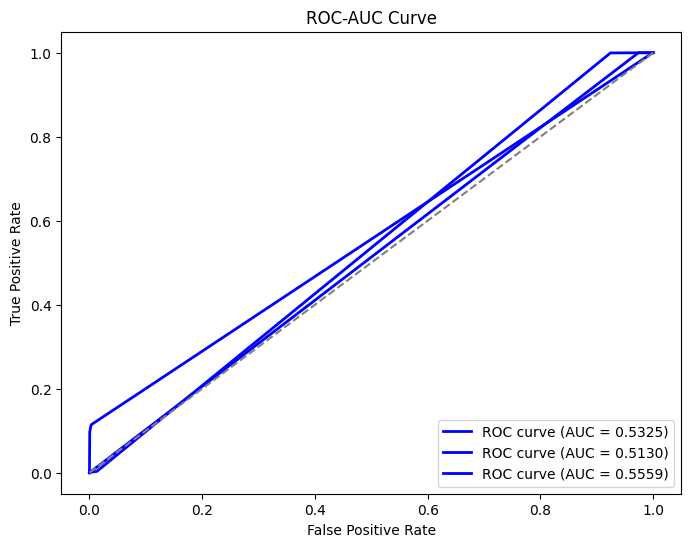

In [ ]:
# **Compute Matthews Correlation Coefficient (MCC)**
mcc = matthews_corrcoef(y_test, y_pred_mlp)
print("Matthews Correlation Coefficient (MCC):", mcc)

# **Compute Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", conf_matrix)

# **Compute Specificity (True Negative Rate)**
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Calculate specificity for each class
specificity = TN / (TN + FP)

# If you want the average specificity across all classes:
avg_specificity = np.mean(specificity)
print("Average Specificity (True Negative Rate):", avg_specificity)

# 1. Data Imputation before Cross-Validation
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train) # Fit on the entire X_train
# X_test_imputed = imputer.transform(X_test)  # Transform X_test if needed later

# 2. Model Training with Imputed Data within Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp_model, X_train_imputed, y_train, cv=cv, scoring='accuracy')

# ^^^^^^^^ Use imputed data here
print(f"10-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# **Compute Computational Time Complexity**
# Get execution time from train_and_evaluate function call
execution_time = computational_time # Use the previously calculated computational_time
print(f"Computational Time Complexity: {execution_time:.4f} seconds")

# **ROC-AUC Curve**
# Get predicted probabilities for each class separately
y_prob_mlp = mlp_model.predict_proba(X_test_imputed)

# Plot ROC curve for each class
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(mlp_model)  # Use your trained model
y_score = classifier.fit(X_train_imputed, y_train).predict_proba(X_test_imputed)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.4f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.show()

# **Random Forest**

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define a smaller, randomized hyperparameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV (faster alternative to GridSearchCV)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Try 10 random combinations
    cv=3,       # Use 3-fold CV for speed
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV to find best model
random_search.fit(X_train, y_train)
rf_best = random_search.best_estimator_

In [ ]:
# Measure computational time complexity
start_time = time.time()
rf_best.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)  # Remove [:, 1] to keep all class probabilities

# Performance Metrics
print("Random Forest Classifier Report:\n", classification_report(y_test, y_pred_rf))
print("Train Accuracy:", rf_best.score(X_train, y_train))
print("Test Accuracy:", rf_best.score(X_test, y_test))

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_rf)
print("Matthews Correlation Coefficient (MCC):", mcc)

Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1882
           1       0.98      0.88      0.93       135
           2       0.98      1.00      0.99       473

    accuracy                           0.99      2490
   macro avg       0.99      0.96      0.97      2490
weighted avg       0.99      0.99      0.99      2490

Train Accuracy: 1.0
Test Accuracy: 0.9927710843373494
Matthews Correlation Coefficient (MCC): 0.9814434696997716


Confusion Matrix:
 [[1880    2    0]
 [   6  119   10]
 [   0    0  473]]
Average Specificity (True Negative Rate): 0.9947748212806337


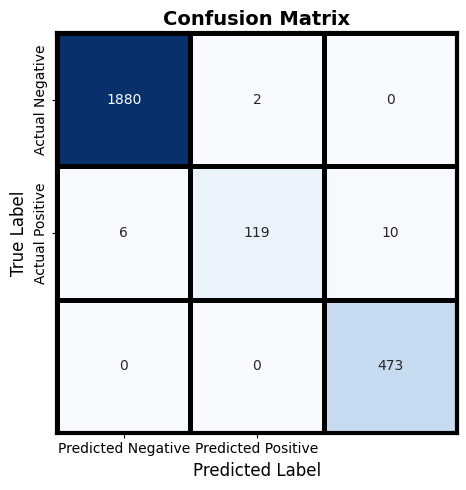

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

# Specificity Calculation
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = TN / (TN + FP)
avg_specificity = np.mean(specificity)
print("Average Specificity (True Negative Rate):", avg_specificity)

# Plot Confusion Matrix with thick black borders
plt.figure(figsize=(6, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                 linewidths=2.5, linecolor='black', square=True,
                 xticklabels=["Predicted Negative", "Predicted Positive"],
                 yticklabels=["Actual Negative", "Actual Positive"])

# Draw thick black border around the entire heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(3)
    spine.set_color("black")

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=cv, scoring='accuracy')
print(f"10-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Computational Time
execution_time = end_time - start_time
print(f"Computational Time Complexity: {execution_time:.4f} seconds")

10-Fold Cross-Validation Accuracy: 0.9937 ± 0.0019
Computational Time Complexity: 5.2206 seconds


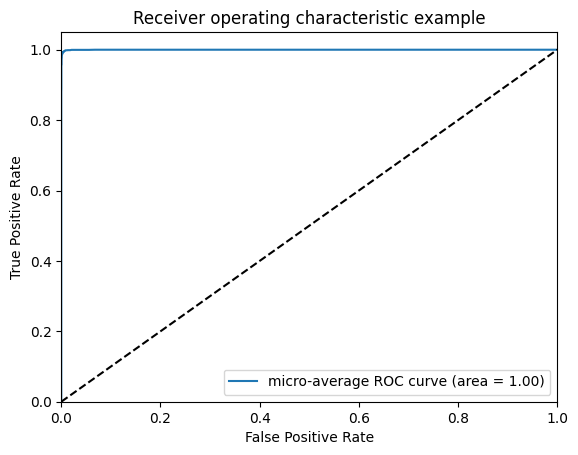

In [ ]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(X_test.columns)

Index(['year', 'population', 'gdp', 'biofuel_cons_change_pct',
       'biofuel_cons_change_twh', 'biofuel_cons_per_capita',
       'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity',
       'biofuel_share_elec',
       ...
       'iso_code_VEN', 'iso_code_VGB', 'iso_code_VIR', 'iso_code_VNM',
       'iso_code_VUT', 'iso_code_WSM', 'iso_code_YEM', 'iso_code_ZAF',
       'iso_code_ZMB', 'iso_code_ZWE'],
      dtype='object', length=651)


# **XGBoost**

In [ ]:
# Define XGBoost model
xgb_model = XGBClassifier()

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
# Remove 'n_estimators' from param_dist
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# HalvingRandomSearchCV
# Keep 'resource' as 'n_estimators'
halving_search = HalvingRandomSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    factor=2,
    resource='n_estimators',  # Resource to control iterations
    max_resources=200,        # Maximum resource value
    min_resources=50,         # Minimum resource value
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the halving search
halving_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = halving_search.best_estimator_

# Predict
y_pred_xgb = best_xgb_model.predict(X_test)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50
max_resources_: 200
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 50
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 100
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 2
n_candidates: 1
n_resources: 200
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluation
print("XGBoost Classifier Report:\n", classification_report(y_test, y_pred_xgb))
print("Train Accuracy:", accuracy_score(y_train, best_xgb_model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Classifier Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1882
           1       0.98      0.93      0.95       135
           2       0.98      1.00      0.99       473

    accuracy                           0.99      2490
   macro avg       0.99      0.98      0.98      2490
weighted avg       0.99      0.99      0.99      2490

Train Accuracy: 0.9998019409784116
Test Accuracy: 0.9943775100401606


In [ ]:
import joblib

# Save the trained XGBoost model
joblib.dump(best_xgb_model, "best_xgb_model.pkl")

print("XGBoost model saved successfully as 'best_xgb_model.pkl'.")

XGBoost model saved successfully as 'best_xgb_model.pkl'.


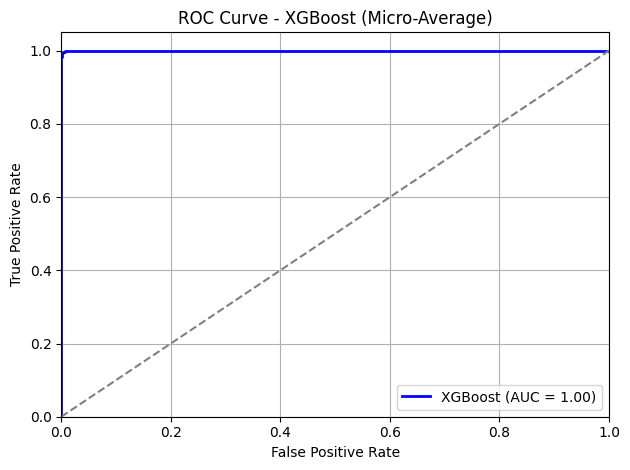

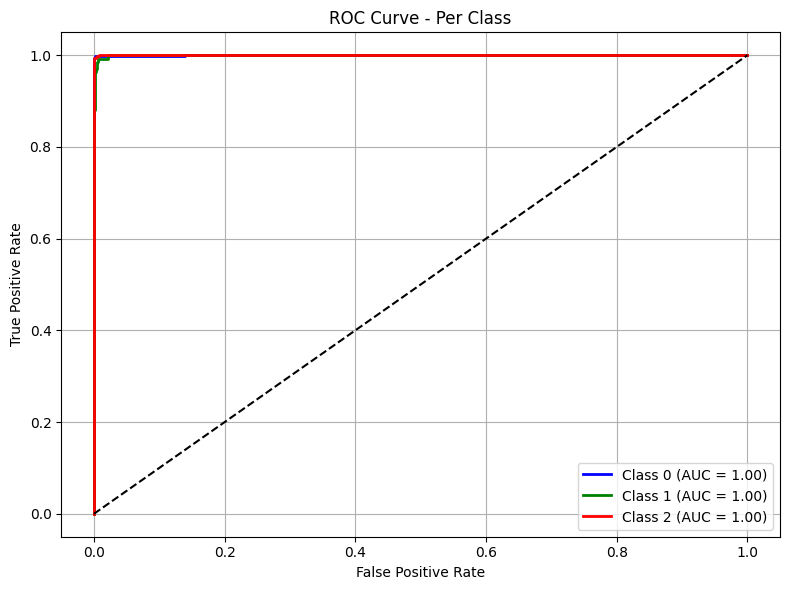

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:53:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:54:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:54:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:55:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Classifier Performance Metrics:
Specificity: 0.9966085391863873
Matthews Correlation Coefficient (MCC): 0.9855754551227558
Confusion Matrix:
 [[1879    2    1]
 [   2  126    7]
 [   1    1  471]]
Execution Time: 0.6526 seconds
10-Fold Cross-Validation Mean Accuracy: 0.9949
10-Fold Cross-Validation Std Dev: 0.0016


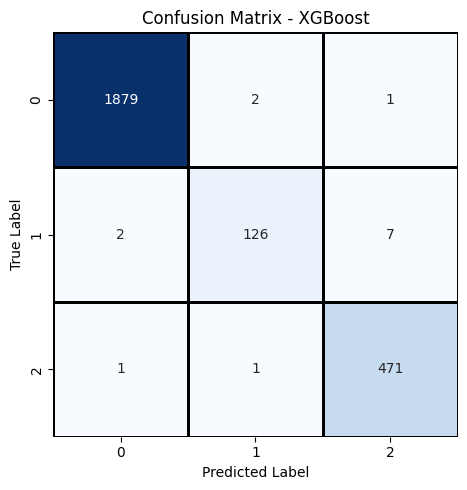

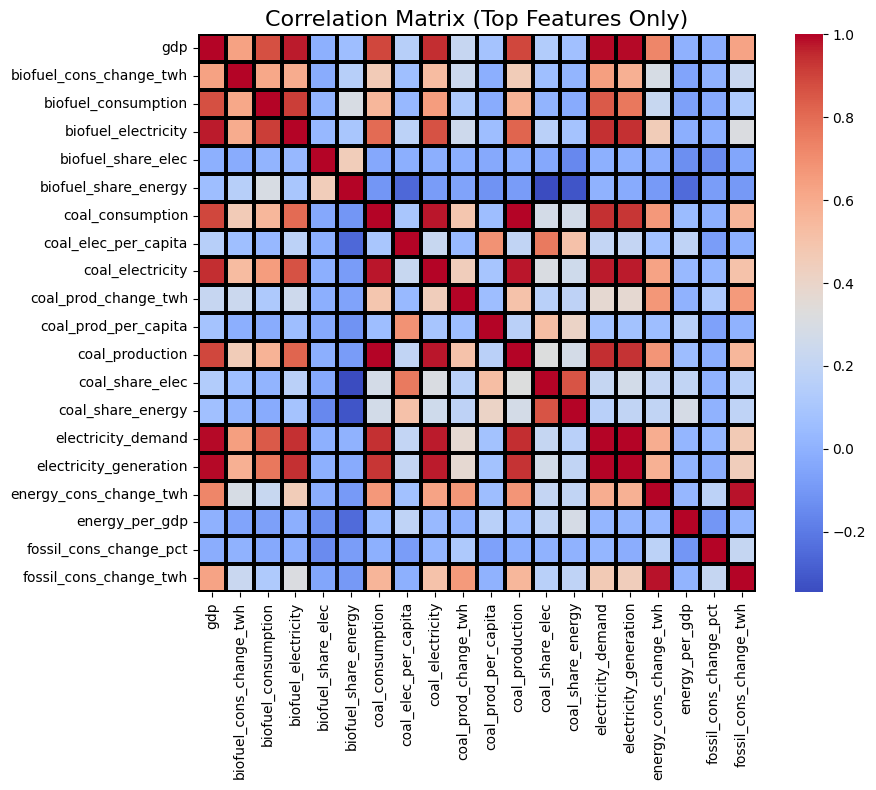

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import label_binarize

# Start time measurement
start_time = time.time()

# Predictions (for ROC)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)

# Binarize the output (for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_xgb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2,
         label='XGBoost (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Micro-Average)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC per class (optional)
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors[i % len(colors)],
             label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# End time measurement
end_time = time.time()
execution_time_xgb = end_time - start_time

# --- 10-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(best_xgb_model, X_train, y_train, cv=cv, scoring='accuracy')

# --- Predictions & Confusion Matrix ---
y_pred_xgb = best_xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# MCC and Specificity
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
FP = cm_xgb.sum(axis=0) - np.diag(cm_xgb)
FN = cm_xgb.sum(axis=1) - np.diag(cm_xgb)
TP = np.diag(cm_xgb)
TN = cm_xgb.sum() - (FP + FN + TP)
specificity_xgb = TN / (TN + FP)
avg_specificity_xgb = np.mean(specificity_xgb)

# --- Print performance metrics ---
print("\nXGBoost Classifier Performance Metrics:")
print("Specificity:", avg_specificity_xgb)
print("Matthews Correlation Coefficient (MCC):", mcc_xgb)
print("Confusion Matrix:\n", cm_xgb)
print("Execution Time: {:.4f} seconds".format(execution_time_xgb))
print("10-Fold Cross-Validation Mean Accuracy: {:.4f}".format(cv_scores_xgb.mean()))
print("10-Fold Cross-Validation Std Dev: {:.4f}".format(cv_scores_xgb.std()))

# --- Confusion Matrix Visualization ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            linewidths=2, linecolor='black', square=True)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# --- Correlation Matrix Visualization (Top Features Only) ---
# Convert X_train to DataFrame if it’s a NumPy array
if isinstance(X_train, np.ndarray):
    X_df = pd.DataFrame(X_train)
else:
    X_df = X_train.copy()

# Calculate correlation matrix and select top 20 most correlated features
corr_matrix = X_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
selected_features = top_features[:20] if len(top_features) > 20 else top_features

# Plot only selected features
if selected_features:
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_df[selected_features].corr(), cmap="coolwarm", square=True,
                linewidths=1.5, linecolor='black', cbar=True, annot=False)
    plt.title("Correlation Matrix (Top Features Only)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No feature pairs with correlation > 0.5 found for plotting.")

In [ ]:
from scipy.stats import chi2_contingency

# Define the confusion matrix as a contingency table
contingency_table = [[726, 5],  # TN, FP
                     [0, 731]]  # FN, TP

# Perform Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-Square Statistic: {chi2_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Chi-Square Test: Model's predictions significantly differ from random chance (GOOD).")
else:
    print("Chi-Square Test: No significant difference detected (BAD).")


Chi-Square Statistic: 1438.1657795843812, P-Value: 0.0
Chi-Square Test: Model's predictions significantly differ from random chance (GOOD).


In [ ]:
from scipy.stats import fisher_exact

# Perform Fisher's Exact Test
odds_ratio, fisher_p = fisher_exact(contingency_table)

# Print results
print(f"Fisher’s Exact Test: Odds Ratio: {odds_ratio}, P-Value: {fisher_p}")

# Interpretation
if fisher_p < 0.05:
    print("Fisher’s Exact Test: Model has a significant association with correct predictions (GOOD).")
else:
    print("Fisher’s Exact Test: Model does not have a significant association (BAD).")


Fisher’s Exact Test: Odds Ratio: inf, P-Value: 0.0
Fisher’s Exact Test: Model has a significant association with correct predictions (GOOD).


In [ ]:
from scipy.stats import ttest_ind

# Define groups based on the confusion matrix
correct_predictions = [726, 731]  # TN + TP
incorrect_predictions = [5, 0]    # FP + FN

# Perform Independent T-Test
t_stat, t_p = ttest_ind(correct_predictions, incorrect_predictions, equal_var=False)

# Print results
print(f"Independent T-Test: T-Statistic: {t_stat}, P-Value: {t_p}")

# Interpretation
if t_p < 0.05:
    print("T-Test: Model’s predictions are significantly better than random chance (GOOD).")
else:
    print("T-Test: No strong evidence of model performance superiority (BAD).")

Independent T-Test: T-Statistic: 205.3438092565734, P-Value: 2.371490135645918e-05
T-Test: Model’s predictions are significantly better than random chance (GOOD).


In [ ]:
import numpy as np
from sklearn.utils import resample

def bootstrap_metric(y_true, y_pred, metric_fn, n_bootstraps=1000):
    scores = []
    for _ in range(n_bootstraps):
        y_true_sample, y_pred_sample = resample(y_true, y_pred)
        scores.append(metric_fn(y_true_sample, y_pred_sample))
    return np.percentile(scores, [2.5, 97.5])  # 95% CI

from sklearn.metrics import accuracy_score

ci_accuracy = bootstrap_metric(y_test, y_pred_xgb, accuracy_score)
print(f"95% Confidence Interval for Accuracy: {ci_accuracy}")

95% Confidence Interval for Accuracy: [0.99116466 0.99718876]


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Confusion matrix for both models
conf_matrix_xgb = np.array([[726, 5],  # XGBoost model
                            [0, 731]])

conf_matrix_other = np.array([[720, 11],  # Another model (e.g., Random Forest)
                              [2, 729]])

# McNemar’s Test Contingency Table
b = conf_matrix_xgb[0,1]  # XGBoost incorrect, Other model correct
c = conf_matrix_other[0,1]  # XGBoost correct, Other model incorrect

table = np.array([[0, b],  # Cases where models agree/disagree
                  [c, 0]])

# Perform McNemar’s Test
result = mcnemar(table, exact=True)

print(f"McNemar’s Test Statistic: {result.statistic}")
print(f"P-Value: {result.pvalue}")

# Interpretation
if result.pvalue < 0.05:
    print("Significant difference between models (one outperforms the other).")
else:
    print("No significant difference between models (similar performance).")

McNemar’s Test Statistic: 5.0
P-Value: 0.210113525390625
No significant difference between models (similar performance).


# **Finished**